# Генератор датасета

## Импорт библиотек

In [54]:
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from pathlib import Path
from enum import Enum, auto
from typing import List, Dict, Optional, Any

## Кастомные исключения и перечисление для режимов генерации

In [55]:
class GenerationMode(Enum):
    """Режимы работы генератора."""

    UNTIL_SOLD = auto()
    FIXED_ROWS = auto()


class EmptyGenerationSetException(Exception):
    """Нет ни одной комбинации, удовлетворяющей заданным параметрам генерации."""

    pass


class GenerationException(Exception):
    """Ошибка во время процесса генерации."""

    pass

## Класс DatasetGenerator

In [56]:
class DatasetGenerator:
    """Генератор случайных «заказов» на основе JSON-файла с товарами."""

    def __init__(
        self,
        json_name: str,
        min_order_price: Optional[float | int] = None,
        max_order_price: Optional[float | int] = None,
        min_order_items: Optional[int] = None,
        max_order_items: Optional[int] = None,
        allow_duplicates: bool = True,
        mode: GenerationMode = GenerationMode.UNTIL_SOLD,
        num_rows: Optional[int] = None,
    ) -> None:
        """
        Инициализирует генератор заказов на основе JSON-файла.

        Параметры:
            json_name (str): Путь к JSON-файлу с описанием товаров.
            min_order_price (Optional[float | int]): Минимальная сумма одного заказа.
            max_order_price (Optional[float | int]): Максимальная сумма одного заказа.
            min_order_items (Optional[int]): Минимальное число позиций в одном заказе.
            max_order_items (Optional[int]): Максимальное число позиций в одном заказе.
            allow_duplicates (bool): Разрешить ли несколько единиц одного товара в заказе.
            mode (GenerationMode): Режим генерации (UNTIL_SOLD или FIXED_ROWS).
            num_rows (Optional[int]): Число строк (заказов) при режиме FIXED_ROWS.
        """

        self.json_name = json_name
        self.min_order_price = min_order_price
        self.max_order_price = max_order_price
        self.min_order_items = min_order_items
        self.max_order_items = max_order_items

        self._validate_min_max()

        self.allow_duplicates = allow_duplicates
        self.mode = mode
        self.num_rows = num_rows

        self._validate_mode_and_num_rows()

        self._load_data()

    @property
    def json_name(self) -> str:
        """Путь к JSON-файлу с описанием товаров."""
        return self._json_name

    @json_name.setter
    def json_name(self, value: str) -> None:
        if not isinstance(value, str):
            raise TypeError("Имя файла должно быть строкой")
        if not Path(value).exists():
            raise FileNotFoundError(f"Файл '{value}' не найден")
        if not value.lower().endswith(".json"):
            raise ValueError("Файл должен иметь расширение .json")
        self._json_name = value

    @property
    def min_order_price(self) -> Optional[float]:
        """Нижняя граница суммы заказа."""
        return self._min_order_price

    @min_order_price.setter
    def min_order_price(self, value: Optional[float | int]) -> None:
        if value is not None:
            if not isinstance(value, (int, float)):
                raise TypeError("min_order_price должен быть числом")
            if value < 0:
                raise ValueError("min_order_price не может быть отрицательным")
        self._min_order_price = float(value) if value is not None else None

    @property
    def max_order_price(self) -> Optional[float]:
        """Верхняя граница суммы заказа."""
        return self._max_order_price

    @max_order_price.setter
    def max_order_price(self, value: Optional[float | int]) -> None:
        if value is not None:
            if not isinstance(value, (int, float)):
                raise TypeError("max_order_price должен быть числом")
            if value < 0:
                raise ValueError("max_order_price не может быть отрицательным")
        self._max_order_price = float(value) if value is not None else None

    @property
    def min_order_items(self) -> Optional[int]:
        """Минимальное число товарных позиций в заказе."""
        return self._min_order_items

    @min_order_items.setter
    def min_order_items(self, value: Optional[int]) -> None:
        if value is not None:
            if not isinstance(value, int):
                raise TypeError("min_order_items должен быть целым числом")
            if value < 0:
                raise ValueError("min_order_items не может быть отрицательным")
        self._min_order_items = int(value) if value is not None else None

    @property
    def max_order_items(self) -> Optional[int]:
        """Максимальное число товарных позиций в заказе."""
        return self._max_order_items

    @max_order_items.setter
    def max_order_items(self, value: Optional[int]) -> None:
        if value is not None:
            if not isinstance(value, int):
                raise TypeError("max_order_items должен быть целым числом")
            if value < 0:
                raise ValueError("max_order_items не может быть отрицательным")
        self._max_order_items = int(value) if value is not None else None

    @property
    def allow_duplicates(self) -> bool:
        """Флаг: можно ли несколько единиц одного товара в заказе."""
        return self._allow_duplicates

    @allow_duplicates.setter
    def allow_duplicates(self, value: bool) -> None:
        if not isinstance(value, bool):
            raise ValueError("allow_duplicates должен быть булевым")
        self._allow_duplicates = value

    @property
    def mode(self) -> GenerationMode:
        """Режим генерации."""
        return self._mode

    @mode.setter
    def mode(self, value: GenerationMode) -> None:
        if not isinstance(value, GenerationMode):
            raise ValueError("mode должен быть элементом GenerationMode")
        self._mode = value

    @property
    def num_rows(self) -> Optional[int]:
        """Число строк для режима FIXED_ROWS."""
        return self._num_rows

    @num_rows.setter
    def num_rows(self, value: Optional[int]) -> None:
        if value is not None:
            if not isinstance(value, int):
                raise TypeError("num_rows должен быть целым числом")
            if value < 0:
                raise ValueError("num_rows не может быть отрицательным")
        self._num_rows = value

    def _validate_min_max(self) -> None:
        """
        Проверяет, что min_order_price < max_order_price и
        min_order_items < max_order_items (если оба заданы).

        Исключения:
            ValueError
        """
        if self.min_order_price is not None and self.max_order_price is not None:
            if self.min_order_price >= self.max_order_price:
                raise ValueError(
                    f"min_order_price должен быть меньше max_order_price: {self.min_order_price} < {self.max_order_price} - False"
                )
        if self.min_order_items is not None and self.max_order_items is not None:
            if self.min_order_items >= self.max_order_items:
                raise ValueError(
                    f"min_order_items должен быть меньше max_order_items: {self.min_order_items} < {self.max_order_items} - False"
                )

    def _validate_mode_and_num_rows(self) -> None:
        """
        Проверяет согласованность mode и num_rows:
        - UNTIL_SOLD требует num_rows=None
        - FIXED_ROWS требует num_rows заданным

        Исключения:
            ValueError
        """
        if self.mode == GenerationMode.UNTIL_SOLD and self.num_rows is not None:
            raise ValueError(
                "Для режима генерации UNTIL_SOLD параметр num_rows должен опущен"
            )
        if self.mode == GenerationMode.FIXED_ROWS and self.num_rows is None:
            raise ValueError(
                "Для режима генерации FIXED_ROWS параметр num_rows должен быть задан"
            )

    def _load_data(self) -> None:
        """
        Загружает данные из JSON:
        - self._original_data: список всех товаров (List[Dict])
        - self._headers: список их названий (List[str])

        Исключения:
            ValueError, RuntimeError
        """
        try:
            with open(self._json_name, "r", encoding="utf-8") as f:
                raw = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Ошибка парсинга JSON-файла: {e}")
        except Exception as e:
            raise RuntimeError(
                f"Непредвиденная ошибка при чтении {self._json_name}: {e}"
            )

        if not isinstance(raw, dict):
            raise ValueError(
                "Ожидался словарь со строками в ключах и списками словарей в значениях"
            )

        self._original_data = []
        self._headers = []
        for items in raw.values():
            if 'teremok' in self.json_name:
                for item in items:
                    item['Цена'] = float(item['Цена'].rstrip('₽'))
            self._original_data.extend(items)
            for item in items:
                if "Позиция" in item:
                    self._headers.append(item["Позиция"])
                elif "Название продукта" in item:
                    self._headers.append(item["Название продукта"])

    def generate_dataset(self) -> pd.DataFrame:
        """
        Формирует DataFrame заказов в зависимости от режима.

        Возвращает:
            pd.DataFrame: строки — заказы, столбцы — позиции.
        """
        if self.mode == GenerationMode.FIXED_ROWS:
            rows = self._generate_fixed_rows()
        elif self.mode == GenerationMode.UNTIL_SOLD:
            rows = self._generate_until_sold()
        return pd.DataFrame(rows, columns=self._headers)

    def _generate_fixed_rows(self) -> List[List[int]]:
        """
        Составляет ровно num_rows заказов, каждый удовлетворяет параметрам.

        Возвращает:
            List[List[int]]: список векторов количеств по каждому товару.

        Исключения:
            GenerationException
        """
        data_pool = self._validate_params()
        rows = []
        for _ in range(self.num_rows):
            for attempt in range(10000):
                min_items = self.min_order_items or 1
                max_items = self.max_order_items or len(data_pool)
                num_items = random.randint(min_items, max_items)

                if self.allow_duplicates:
                    chosen = random.choices(data_pool, k=num_items)
                else:
                    chosen = random.sample(data_pool, k=num_items)

                total_price = sum(item["Цена"] for item in chosen)

                if (
                    self.min_order_price is not None
                    and total_price < self.min_order_price
                ):
                    continue
                if (
                    self.max_order_price is not None
                    and total_price > self.max_order_price
                ):
                    continue

                row = [0] * len(self._original_data)
                for item in chosen:
                    idx = self._original_data.index(item)
                    row[idx] += 1

                rows.append(row)
                break
            else:
                raise GenerationException(
                    f"Не удалось сгенерировать строку {_ + 1}/{self.num_rows} "
                    f"за {attempt + 1} попыток"
                )
        return rows

    def _validate_params(self) -> List[Dict[str, Any]]:
        """
        Отбирает товары по max_order_price и проверяет min_order_items
        (при allow_duplicates=False).

        Возвращает:
            List[Dict]: список отфильтрованных товаров.

        Исключения:
            EmptyGenerationSetException
        """
        data = deepcopy(self._original_data)
        if self.max_order_price is not None:
            data = list(
                filter(
                    lambda item: item["Цена"] <= self.max_order_price,
                    self._original_data,
                )
            )
            if not data:
                raise EmptyGenerationSetException(
                    f"Невозможно сгенерировать датасет, не найдено позиций, удовлетворяющих параметрам генерации: max_order_price={self.max_order_price}"
                )
        if self.min_order_items is not None and not self.allow_duplicates:
            total_unique = len(data)
            if self.min_order_items > len(data):
                raise EmptyGenerationSetException(
                    f"Невозможно сгенерировать датасет, не найдено позиций, удовлетворяющих параметрам генерации: min_order_items={self.min_order_items}, allow_duplicates={self.allow_duplicates}. Невозможно выбрать {self.min_order_items} уникальных товаров из {total_unique}"
                )
        return data

    def _generate_until_sold(self) -> List[List[int]]:
        """
        Генерирует заказы, пока есть остатки товаров (поле 'Продано').

        Возвращает:
            List[List[int]]: список векторов количеств по каждому товару.
        """
        data_pool = self._validate_params()
        remaining = [item["Продано"] for item in data_pool]
        rows = []
        while any(rem > 0 for rem in remaining):
            for _ in range(10000):
                min_items = self.min_order_items or 1
                max_items = self.max_order_items or len(data_pool)
                num_items = random.randint(min_items, max_items)

                available_indices = [
                    idx for idx, rem in enumerate(remaining) if rem > 0
                ]
                if not available_indices:
                    return rows

                if self.allow_duplicates:
                    chosen_idxs = random.choices(available_indices, k=num_items)
                else:
                    if num_items > len(available_indices):
                        continue
                    chosen_idxs = random.sample(available_indices, k=num_items)

                cnt = {}
                for i in chosen_idxs:
                    cnt[i] = cnt.get(i, 0) + 1
                    if cnt[i] > remaining[i]:
                        break

                else:
                    total_price = sum(
                        self._original_data[i]["Цена"] * cnt[i] for i in cnt
                    )
                    if (
                        self.min_order_price is not None
                        and total_price < self.min_order_price
                    ):
                        continue
                    if (
                        self.max_order_price is not None
                        and total_price > self.max_order_price
                    ):
                        continue

                    for i, q in cnt.items():
                        remaining[i] -= q

                    row = [0] * len(self._original_data)
                    for i, q in cnt.items():
                        row[i] = q
                    rows.append(row)
                    break
            else:
                remaining_items = [
                    (self._original_data[i]["Позиция"], rem)
                    for i, rem in enumerate(remaining)
                    if rem > 0
                ]
                print(
                    "\033[91m"
                    + f"Не удалось сгенерировать очередную строку в режиме UNTIL_SOLD. "
                    f"Сгенерировано: {len(rows)} строк. Остатки по позициям:"
                    + "\033[0m"
                )
                for name, qty in remaining_items:
                    print(f"  • {name}: {qty}")
                return rows

        return rows

## Пример создания датасета в режиме FIXED_ROWS

In [57]:
dataset_generator = DatasetGenerator(
    "unifood.json",
    min_order_items=2,
    max_order_items=5,
    max_order_price=1000,
    allow_duplicates=False,
    mode=GenerationMode.FIXED_ROWS,
    num_rows=25
)
dataset = dataset_generator.generate_dataset()
print(dataset.to_markdown(index=False))

|   Бургер с говядиной |   Бургер куриный |   Хот-дог куриный |   Булочка с глазурью |   Булочка с корицей |   Булочка с маком |   Ватрушка с творогом |   Пирожок с вишней |   Пирожок с зеленым луком и яйцом |   Пирожок с капустой |   Пирожок с картошкой и грибами |   Пирожок с мясом |   Пирожок с повидлом |   Пирожок с яблоком |   Сосиска в тесте |   Булочка француженка |   Плюшка московская |   Десерт Павлова |   Кекс морковный |   Творожное кольцо |   Красный бархат |   Лимонный тарт |   Медовик |   Миндальный торт |   Наполеон |   Песочная полоска |   Пирожное картошка |   Прага |   Сочник с творогом |   Тирамису |   Птичье молоко |   Три шоколада |   Чизкейк манговое пюре |   Чизкейк Нью-Йорк |   Донаты |   Американо, 200 мл |   Американо, 300 мл |   Какао |   Капучино, 200 мл |   Капучино, 300 мл |   Карамелатте |   Американский, 200 мл |   Американский, 300 мл |   Кофе Капучино, 200 мл |   Кофе Капучино, 300 мл |   Латте, 200 мл |   Латте, 300 мл |   Раф |   Экспрессо, 35 мл |  

## Пример создания датасета в режиме UNTIL_SOLD

In [58]:
dataset_generator = DatasetGenerator(
    "unifood.json",
    min_order_items=2,
    max_order_items=5,
    max_order_price=1000,
    allow_duplicates=False,
    mode=GenerationMode.UNTIL_SOLD,
)
dataset = dataset_generator.generate_dataset()
print(dataset.head(25).to_markdown(index=False))

Не удалось сгенерировать очередную строку в режиме UNTIL_SOLD. Сгенерировано: 22841 строк. Остатки по позициям:
  • Бургер куриный: 3538
|   Бургер с говядиной |   Бургер куриный |   Хот-дог куриный |   Булочка с глазурью |   Булочка с корицей |   Булочка с маком |   Ватрушка с творогом |   Пирожок с вишней |   Пирожок с зеленым луком и яйцом |   Пирожок с капустой |   Пирожок с картошкой и грибами |   Пирожок с мясом |   Пирожок с повидлом |   Пирожок с яблоком |   Сосиска в тесте |   Булочка француженка |   Плюшка московская |   Десерт Павлова |   Кекс морковный |   Творожное кольцо |   Красный бархат |   Лимонный тарт |   Медовик |   Миндальный торт |   Наполеон |   Песочная полоска |   Пирожное картошка |   Прага |   Сочник с творогом |   Тирамису |   Птичье молоко |   Три шоколада |   Чизкейк манговое пюре |   Чизкейк Нью-Йорк |   Донаты |   Американо, 200 мл |   Американо, 300 мл |   Какао |   Капучино, 200 мл |   Капучино, 300 мл |   Карамелатте |   Американский, 200 мл |   Амер

## Обработка ошибок

### Указание num_rows для режима UNTIL_SOLD
Нельзя задавать число строк, так как режим подразумевает генерацию до того момента, пока не будут "проданы" все товары. Поле "Продано" в JSON-файле содержит число продаж продукта за месяц.

In [60]:
dataset_generator = DatasetGenerator(
    "unifood.json",
    min_order_items=2,
    max_order_items=5,
    max_order_price=1000,
    allow_duplicates=False,
    mode=GenerationMode.UNTIL_SOLD,
    num_rows=25
)
dataset = dataset_generator.generate_dataset()
print(dataset.to_markdown(index=False))

ValueError: Для режима генерации UNTIL_SOLD параметр num_rows должен опущен

### Указание неверных типов данных для параметров класса
Все параметры класса заданы через свойства, которые контроллируют корректность типов данных задаваемых параметров.

In [61]:
dataset_generator = DatasetGenerator(
    "unifood.json",
    min_order_items='0',
    max_order_items=5,
    max_order_price=1000,
    allow_duplicates=False,
    mode=GenerationMode.UNTIL_SOLD,
)
dataset = dataset_generator.generate_dataset()
print(dataset.to_markdown(index=False))

TypeError: min_order_items должен быть целым числом

In [62]:
dataset_generator = DatasetGenerator(
    "unifood.json",
    min_order_items=1,
    max_order_items=5,
    max_order_price=1000,
    allow_duplicates=False,
    mode=GenerationMode.FIXED_ROWS,
    num_rows=-5
)
dataset = dataset_generator.generate_dataset()
print(dataset.to_markdown(index=False))

ValueError: num_rows не может быть отрицательным

### Несуществующий JSON-файл
Класс работает только с JSON-файлами определенного формата.

In [63]:
dataset_generator = DatasetGenerator(
    "kunifood.json",
    min_order_items=1,
    max_order_items=5,
    max_order_price=1000,
    allow_duplicates=False,
    mode=GenerationMode.FIXED_ROWS,
    num_rows=5
)
dataset = dataset_generator.generate_dataset()
print(dataset.to_markdown(index=False))

FileNotFoundError: Файл 'kunifood.json' не найден

## Создание датасета
Выберем режим UNTIL_SOLD со следующими параметрами для моделирования реальных заказов студентов:
- min_order_items = 2
- max_order_items = 5
- max_order_price = 1200
- allow_duplicates = False


In [64]:
dataset_generator = DatasetGenerator(
    "unifood.json",
    min_order_items=2,
    max_order_items=5,
    max_order_price=1200,
    allow_duplicates=False,
    mode=GenerationMode.UNTIL_SOLD,
)

dataset = dataset_generator.generate_dataset()
print(dataset.head(100).to_markdown(index=False))

Не удалось сгенерировать очередную строку в режиме UNTIL_SOLD. Сгенерировано: 22745 строк. Остатки по позициям:
  • Бургер куриный: 3464
|   Бургер с говядиной |   Бургер куриный |   Хот-дог куриный |   Булочка с глазурью |   Булочка с корицей |   Булочка с маком |   Ватрушка с творогом |   Пирожок с вишней |   Пирожок с зеленым луком и яйцом |   Пирожок с капустой |   Пирожок с картошкой и грибами |   Пирожок с мясом |   Пирожок с повидлом |   Пирожок с яблоком |   Сосиска в тесте |   Булочка француженка |   Плюшка московская |   Десерт Павлова |   Кекс морковный |   Творожное кольцо |   Красный бархат |   Лимонный тарт |   Медовик |   Миндальный торт |   Наполеон |   Песочная полоска |   Пирожное картошка |   Прага |   Сочник с творогом |   Тирамису |   Птичье молоко |   Три шоколада |   Чизкейк манговое пюре |   Чизкейк Нью-Йорк |   Донаты |   Американо, 200 мл |   Американо, 300 мл |   Какао |   Капучино, 200 мл |   Капучино, 300 мл |   Карамелатте |   Американский, 200 мл |   Амер

# Менеджер датасета

## Класс для анализа сгенерированного датасета

In [66]:
class DatasetManager:
    def __init__(self, dataset: pd.DataFrame) -> None:
        """
        Инициализирует менеджер статистик по датасету.

        Параметры:
            dataset (pd.DataFrame): DataFrame, где строки — транзакции, столбцы — позиции товаров.
        """
        self.dataset: pd.DataFrame = dataset

    def show_dataset_info(self) -> None:
        """
        Выводит основную информацию о датасете:
        число транзакций, число признаков и подробную сводку pandas.
        """
        print(f"Число транзакций: {len(self.dataset)}")
        print(f"Число признаков: {self.dataset.columns.size}")
        self.dataset.info()

    def show_top_n_items(self, n: int) -> None:
        """
        Строит столбчатую диаграмму для первых N товаров по числу транзакций,
        в которых они встречаются.

        Параметры:
            n (int): количество топ-товаров для отображения.
        """
        freq: pd.Series = (self.dataset > 0).sum(axis=0)
        top: pd.Series = freq.sort_values(ascending=False).head(n)

        plt.figure(figsize=(8, 4))
        plt.bar(top.index, top.values)
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Товар")
        plt.ylabel("Число транзакций")
        plt.title(f"Топ {n} товаров по встречаемости в транзакциях")
        plt.tight_layout()
        plt.show()

        print(top)

    def plot_transaction_length_distribution(self) -> None:
        """
        Строит круговую (pie) диаграмму распределения размеров корзин (сумма по строке).
        """
        transaction_lengths: pd.Series = self.dataset.sum(axis=1).astype(int)
        size_counts: pd.Series = transaction_lengths.value_counts().sort_index()

        labels = [
            f"{size} товар{'а' if size < 5 else 'ов'}" for size in size_counts.index
        ]

        plt.figure(figsize=(8, 4))
        plt.pie(
            size_counts,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            colors=plt.cm.Paired.colors,
            wedgeprops={"edgecolor": "black", "linewidth": 0.5},
        )

        plt.title("Распределение размеров корзин")
        plt.tight_layout()
        plt.show()

    def show_basket_stats(self) -> None:
        """
        Выводит основные статистики по размерам корзин:
        среднее, медиану, моду, минимум и максимум.
        """
        transaction_lengths: pd.Series = self.dataset.sum(axis=1)
        print(f"Средний размер корзины: {transaction_lengths.mean():.2f}")
        print(f"Медианный размер: {transaction_lengths.median()}")
        print(f"Мода: {transaction_lengths.mode().iat[0]}")
        print(
            f"Минимум/Максимум: {transaction_lengths.min()}/{transaction_lengths.max()}"
        )

    def check_duplicates(self) -> None:
        """
        Подсчитывает и выводит число полностью дублирующихся транзакций в датасете.
        """
        duplicates: int = self.dataset.duplicated().sum()
        print(f"Число дубликатов транзакций: {duplicates}")

## Общая информация о датасете

In [67]:
dataset_manager = DatasetManager(dataset)

dataset_manager.show_dataset_info()

Число транзакций: 22745
Число признаков: 74
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22745 entries, 0 to 22744
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Бургер с говядиной               22745 non-null  int64
 1   Бургер куриный                   22745 non-null  int64
 2   Хот-дог куриный                  22745 non-null  int64
 3   Булочка с глазурью               22745 non-null  int64
 4   Булочка с корицей                22745 non-null  int64
 5   Булочка с маком                  22745 non-null  int64
 6   Ватрушка с творогом              22745 non-null  int64
 7   Пирожок с вишней                 22745 non-null  int64
 8   Пирожок с зеленым луком и яйцом  22745 non-null  int64
 9   Пирожок с капустой               22745 non-null  int64
 10  Пирожок с картошкой и грибами    22745 non-null  int64
 11  Пирожок с мясом                  22745 non-null  int64
 12  Пи

## Топ N самых популярных товаров

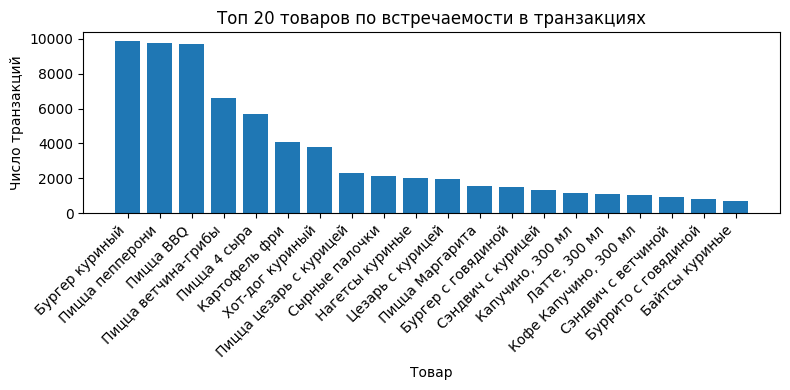

Бургер куриный            9870
Пицца пепперони           9737
Пицца BBQ                 9704
Пицца ветчина-грибы       6579
Пицца 4 сыра              5685
Картофель фри             4090
Хот-дог куриный           3789
Пицца цезарь с курицей    2308
Сырные палочки            2161
Нагетсы куриные           2002
Цезарь с курицей          1955
Пицца Маргарита           1571
Бургер с говядиной        1534
Сэндвич с курицей         1326
Капучино, 300 мл          1178
Латте, 300 мл             1086
Кофе Капучино, 300 мл     1062
Сэндвич с ветчиной         916
Буррито с говядиной        838
Байтсы куриные             704
dtype: int64


In [68]:
dataset_manager.show_top_n_items(20)

## Распределение размеров корзин

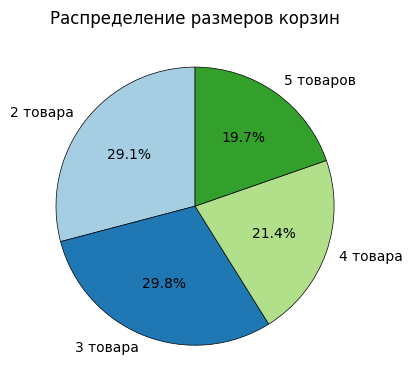

In [69]:
dataset_manager.plot_transaction_length_distribution()

## Статистика по корзинам пользователей

In [70]:
dataset_manager.show_basket_stats()

Средний размер корзины: 3.32
Медианный размер: 3.0
Мода: 3
Минимум/Максимум: 2/5


## Дублирующиеся транзакции

In [71]:
dataset_manager.check_duplicates()

Число дубликатов транзакций: 15493


# APriori (mlxtend)

In [94]:
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

## One-Hot Encoding

In [95]:
def hot_encode(x):
    if x == 0:
        return False
    return True


dataset = dataset.map(hot_encode)
dataset.head()

,Бургер с говядиной,Бургер куриный,Хот-дог куриный,Булочка с глазурью,Булочка с корицей,Булочка с маком,Ватрушка с творогом,Пирожок с вишней,Пирожок с зеленым луком и яйцом,Пирожок с капустой,...,Сырные палочки,Сэндвич с семгой,Сэндвич с курицей,Сэндвич с ветчиной,Апельсиновый фреш,Морковно-яблочный фреш,Морковный фреш,Яблочно-апельсиновый фреш,Яблочный с сельдереем фреш,Яблочный фреш
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Выявление частых наборов

In [96]:
frq_items = apriori(dataset, min_support=0.01, use_colnames=True)
frq_items.sort_values(["support"], ascending=[False])

,support,itemsets
1,0.433942,(Бургер куриный)
17,0.428094,(Пицца пепперони)
14,0.426643,(Пицца BBQ)
18,0.289250,(Пицца ветчина-грибы)
40,0.254781,"(Бургер куриный, Пицца BBQ)"
...,...,...
33,0.010332,"(Бургер с говядиной, Пицца ветчина-грибы)"
42,0.010244,"(Бургер куриный, Пицца Маргарита)"
37,0.010156,"(Нагетсы куриные, Бургер с говядиной)"
38,0.010156,"(Сырные палочки, Бургер с говядиной)"


## Генерация ассоциативных правил

In [97]:
rules = association_rules(frq_items, metric="lift", min_threshold=1)
rules.sort_values(["lift"], ascending=[False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
292,"(Бургер куриный, Пицца ветчина-грибы)","(Пицца пепперони, Пицца 4 сыра, Пицца BBQ)",0.140207,0.061596,0.029721,0.211979,3.441438,1.0,0.021085,1.190836,0.825110,0.172713,0.160254,0.347246
285,"(Пицца пепперони, Пицца 4 сыра, Пицца BBQ)","(Бургер куриный, Пицца ветчина-грибы)",0.061596,0.140207,0.029721,0.482512,3.441438,1.0,0.021085,1.661477,0.755990,0.172713,0.398126,0.347246
295,"(Пицца ветчина-грибы, Пицца BBQ)","(Пицца пепперони, Пицца 4 сыра, Бургер куриный)",0.136865,0.064234,0.029721,0.217154,3.380674,1.0,0.020929,1.195338,0.815864,0.173422,0.163417,0.339925
282,"(Пицца пепперони, Пицца 4 сыра, Бургер куриный)","(Пицца ветчина-грибы, Пицца BBQ)",0.064234,0.136865,0.029721,0.462697,3.380674,1.0,0.020929,1.606420,0.752540,0.173422,0.377498,0.339925
297,"(Пицца пепперони, Пицца ветчина-грибы)","(Пицца 4 сыра, Бургер куриный, Пицца BBQ)",0.141965,0.064630,0.029721,0.209353,3.239271,1.0,0.020546,1.183044,0.805665,0.168034,0.154723,0.334608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,(Хот-дог куриный),(Пицца Маргарита),0.166586,0.069070,0.011563,0.069411,1.004942,1.0,0.000057,1.000367,0.005900,0.051599,0.000367,0.118410
131,(Хот-дог куриный),"(Пицца 4 сыра, Пицца BBQ)",0.166586,0.112596,0.018817,0.112959,1.003218,1.0,0.000060,1.000409,0.003849,0.072273,0.000408,0.140040
128,"(Пицца 4 сыра, Пицца BBQ)",(Хот-дог куриный),0.112596,0.166586,0.018817,0.167122,1.003218,1.0,0.000060,1.000644,0.003615,0.072273,0.000643,0.140040
143,"(Пицца 4 сыра, Пицца ветчина-грибы)",(Хот-дог куриный),0.112904,0.166586,0.018817,0.166667,1.000484,1.0,0.000009,1.000097,0.000545,0.072188,0.000097,0.139813


## Визуализация метрик

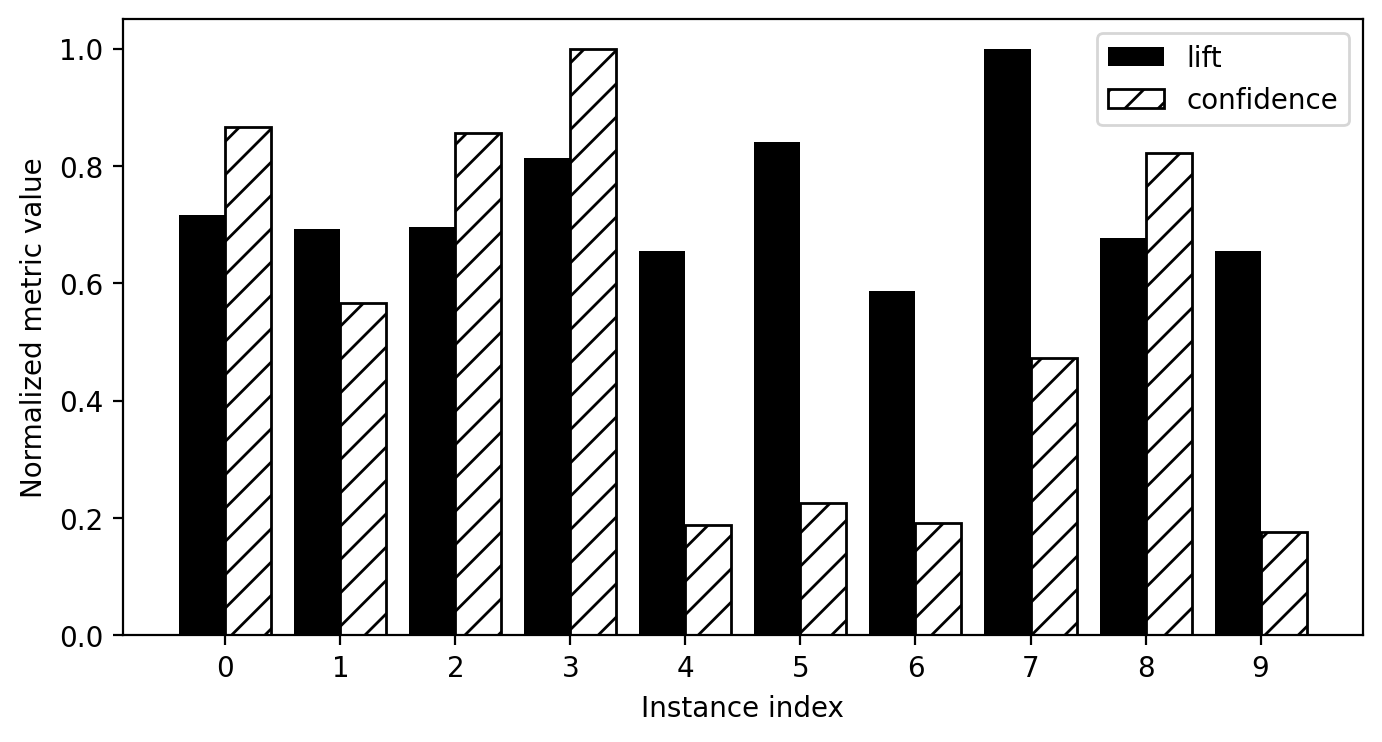

In [98]:
rules_random = rules.sample(10, random_state=42)
rules_lift = rules_random[["lift"]].to_numpy()
rules_lift = (rules_lift / rules_lift.max()).transpose()[0]
rules_conf = rules_random[["confidence"]].to_numpy()
rules_conf = (rules_conf / rules_conf.max()).transpose()[0]
width = 0.40
plt.figure(figsize=(8, 4), dpi=200)

plt.bar(np.arange(len(rules_random)) - 0.2, rules_lift, width, color="black")
plt.bar(
    np.arange(len(rules_random)) + 0.2,
    rules_conf,
    width,
    hatch="//",
    edgecolor="black",
    facecolor="white",
)
plt.xlabel("Instance index")
plt.ylabel("Normalized metric value")
plt.legend(["lift", "confidence"])
plt.xticks(range(0, 10))
plt.show()

# APriori

In [82]:
from dataclasses import dataclass
from itertools import combinations
from typing import Optional, Set, FrozenSet
from math import inf

## Перечисление для метрик

In [88]:
class Metric(str, Enum):
    """Метрики качества ассоциативных правил."""

    SUPPORT = "support"
    CONFIDENCE = "confidence"
    CONVICTION = "conviction"
    LIFT = "lift"
    LEVERAGE = "leverage"

## Фильтр для ассоциативных правил

In [89]:
@dataclass(frozen=True)
class RuleFilter:
    """
    Описывает одно условие фильтрации:
      metric — по какой метрике фильтруем,
      min_threshold — минимально допустимое значение (или None),
      max_threshold — максимально допустимое значение (или None).
    """

    metric: Metric
    min_threshold: Optional[float] = None
    max_threshold: Optional[float] = None

## Класс APriori

In [90]:
class APriori:
    def __init__(self, dataset: pd.DataFrame) -> None:
        """
        Инициализирует датасет для поиска частых наборов и построения правил.

        Параметры:
            dataset (pd.DataFrame): one-hot–кодированный DataFrame транзакций,
                где столбцы — товары, строки — транзакции, значения 0/1 или False/True.
        """
        self.dataset = dataset

    def apriori(
        self, min_support: float = 0.25, max_len: Optional[int] = None
    ) -> pd.DataFrame:
        """
        Находит частые наборы элементов методом Apriori.

        Параметры:
            min_support (float): минимальная поддержка в диапазоне [0.0, 1.0].
            max_len (Optional[int]): максимальный размер наборов (None — без ограничения).

        Возвращает:
            pd.DataFrame с колонками:
                - itemsets (frozenset): частый набор элементов,
                - support (float): доля транзакций, содержащих этот набор.
        """
        if not isinstance(min_support, (float, int)):
            raise TypeError("Минимальное значение support должно быть числом")
        if min_support < 0 or min_support > 1:
            raise ValueError(
                "Минимальное значение support должно находиться в диапазоне [0;1]"
            )
        if max_len is not None:
            if not isinstance(max_len, int):
                raise TypeError("Значение max_len должно быть целым числом")
            if max_len < 0:
                raise ValueError("Значение max_len должно быть положительным числом")

        df = self.dataset
        n_transactions = len(df)

        support_data = {}
        L = []
        for col in df.columns:
            sup = df[col].sum() / n_transactions
            if sup >= min_support:
                itemset = frozenset([col])
                support_data[itemset] = sup
                L.append({col})

        k = 2
        prev_L = L

        while prev_L and (max_len is None or k <= max_len):
            Ck = set()
            for i in range(len(prev_L)):
                for j in range(i + 1, len(prev_L)):
                    union_set = prev_L[i] | prev_L[j]
                    if len(union_set) == k:
                        subsets = combinations(union_set, k - 1)
                        if all(
                            frozenset(sub) in map(frozenset, prev_L) for sub in subsets
                        ):
                            Ck.add(frozenset(union_set))

            next_L = []
            for candidate in Ck:
                mask = df[list(candidate)].all(axis=1)
                sup = mask.sum() / n_transactions
                if sup >= min_support:
                    support_data[candidate] = sup
                    next_L.append(set(candidate))

            prev_L = next_L
            k += 1

        result = pd.DataFrame(
            [
                {"itemsets": itemset, "support": support}
                for itemset, support in support_data.items()
            ]
        )
        return result

    def association_rules(
        self, frequent_itemsets: pd.DataFrame, filters: List[RuleFilter]
    ) -> pd.DataFrame:
        """
        Строит ассоциативные правила из частых наборов и фильтрует их.

        Параметры:
            frequent_itemsets (pd.DataFrame): результат apriori,
                колонки itemsets (frozenset) и support (float).
            filters (List[RuleFilter]): список условий фильтрации по метрикам.

        Возвращает:
            pd.DataFrame с колонками:
                - antecedents (frozenset)
                - consequents (frozenset)
                - support (float)
                - confidence (float)
                - lift (float)
                - leverage (float)
                - conviction (float)
            и только теми строками, которые проходят все фильтры.
        """
        df_bool = self.dataset

        support_map = {
            frozenset(row["itemsets"]): float(row["support"])
            for _, row in frequent_itemsets.iterrows()
        }

        records = []

        for itemset, support_AB in support_map.items():
            if len(itemset) < 2:
                continue
            for r in range(1, len(itemset)):
                for antecedent in combinations(itemset, r):
                    X = frozenset(antecedent)
                    Y = itemset - X
                    support_A = support_map.get(X)
                    support_B = support_map.get(Y)
                    if support_B is None:
                        mask_B = df_bool[list(Y)].all(axis=1)
                        support_B = float(mask_B.sum()) / len(df_bool)
                    confidence = support_AB / support_A
                    lift = confidence / support_B
                    leverage = support_AB - support_A * support_B
                    conviction = (
                        (1 - support_B) / (1 - confidence) if confidence != 1 else inf
                    )

                    records.append(
                        {
                            "antecedents": X,
                            "consequents": Y,
                            "support": support_AB,
                            "confidence": confidence,
                            "lift": lift,
                            "leverage": leverage,
                            "conviction": conviction,
                        }
                    )

        rules_df = pd.DataFrame(records)

        for f in filters:
            col = f.metric.value
            if f.min_threshold is not None:
                rules_df = rules_df[rules_df[col] >= f.min_threshold]
            if f.max_threshold is not None:
                rules_df = rules_df[rules_df[col] <= f.max_threshold]

        return rules_df

## Выявление частых наборов

In [114]:
apriori_custom = APriori(dataset)
frequent_itemsets = apriori_custom.apriori(min_support=0.01)
frequent_itemsets.sort_values(["support"], ascending=[False])

,itemsets,support
1,(Бургер куриный),0.433942
17,(Пицца пепперони),0.428094
14,(Пицца BBQ),0.426643
18,(Пицца ветчина-грибы),0.289250
95,"(Бургер куриный, Пицца BBQ)",0.254781
...,...,...
59,"(Бургер с говядиной, Пицца ветчина-грибы)",0.010332
41,"(Бургер куриный, Пицца Маргарита)",0.010244
48,"(Сырные палочки, Бургер с говядиной)",0.010156
56,"(Нагетсы куриные, Бургер с говядиной)",0.010156


## Генерация ассоциативных правил

In [115]:
filters = [RuleFilter(Metric.LIFT, min_threshold=1)]

rules = apriori_custom.association_rules(frequent_itemsets, filters)

rules.sort_values(["lift"], ascending=[False])

,antecedents,consequents,support,confidence,lift,leverage,conviction
448,"(Бургер куриный, Пицца ветчина-грибы)","(Пицца пепперони, Пицца 4 сыра, Пицца BBQ)",0.029721,0.211979,3.441438,0.021085,1.190836
449,"(Пицца пепперони, Пицца 4 сыра, Пицца BBQ)","(Бургер куриный, Пицца ветчина-грибы)",0.029721,0.482512,3.441438,0.021085,1.661477
455,"(Пицца пепперони, Пицца 4 сыра, Бургер куриный)","(Пицца ветчина-грибы, Пицца BBQ)",0.029721,0.462697,3.380674,0.020929,1.606420
442,"(Пицца ветчина-грибы, Пицца BBQ)","(Пицца пепперони, Пицца 4 сыра, Бургер куриный)",0.029721,0.217154,3.380674,0.020929,1.195338
445,"(Пицца пепперони, Пицца ветчина-грибы)","(Пицца 4 сыра, Бургер куриный, Пицца BBQ)",0.029721,0.209353,3.239271,0.020546,1.183044
...,...,...,...,...,...,...,...
87,(Хот-дог куриный),(Пицца Маргарита),0.011563,0.069411,1.004942,0.000057,1.000367
161,(Хот-дог куриный),"(Пицца 4 сыра, Пицца BBQ)",0.018817,0.112959,1.003218,0.000060,1.000409
164,"(Пицца 4 сыра, Пицца BBQ)",(Хот-дог куриный),0.018817,0.167122,1.003218,0.000060,1.000644
305,(Хот-дог куриный),"(Пицца 4 сыра, Пицца ветчина-грибы)",0.018817,0.112959,1.000484,0.000009,1.000062


## Пример генерации правил с фильтрацией по нескольким метрикам

In [121]:
filters_example = [RuleFilter(Metric.LIFT, min_threshold=1), RuleFilter(Metric.CONFIDENCE, min_threshold=0.25), RuleFilter(Metric.SUPPORT, max_threshold=0.02)]

rules_example = apriori_custom.association_rules(frequent_itemsets, filters_example)

rules_example.sort_values(["lift"], ascending=[False])

,antecedents,consequents,support,confidence,lift,leverage,conviction
271,"(Хот-дог куриный, Пицца ветчина-грибы)",(Картофель фри),0.019609,0.364379,2.026358,0.009932,1.290361
157,"(Пицца 4 сыра, Хот-дог куриный)",(Картофель фри),0.018378,0.357877,1.990197,0.009144,1.277294
229,"(Бургер куриный, Хот-дог куриный)",(Картофель фри),0.018158,0.346477,1.926799,0.008734,1.255013
349,"(Пицца пепперони, Хот-дог куриный)",(Картофель фри),0.018246,0.346411,1.926433,0.008774,1.254886
205,"(Хот-дог куриный, Пицца BBQ)",(Картофель фри),0.018685,0.346373,1.926225,0.008985,1.254814
273,"(Пицца ветчина-грибы, Картофель фри)",(Хот-дог куриный),0.019609,0.319943,1.920585,0.009399,1.225505
207,"(Пицца BBQ, Картофель фри)",(Хот-дог куриный),0.018685,0.318591,1.912469,0.008915,1.223074
350,"(Пицца пепперони, Картофель фри)",(Хот-дог куриный),0.018246,0.313918,1.884421,0.008563,1.214744
158,"(Пицца 4 сыра, Картофель фри)",(Хот-дог куриный),0.018378,0.311243,1.868364,0.008541,1.210027
230,"(Бургер куриный, Картофель фри)",(Хот-дог куриный),0.018158,0.296482,1.779755,0.007955,1.184638


# Eclat

## Класс Eclat

In [122]:
class Eclat:
    def __init__(self, dataset: pd.DataFrame) -> None:
        """
        Инициализирует объект для поиска частых наборов методом Eclat.

        Параметры:
            dataset (pd.DataFrame): one-hot–кодированный DataFrame транзакций,
                где столбцы — товары, строки — транзакции, значения 0/1 или False/True.
        """
        self.dataset = dataset > 0

    def eclat(
        self, min_support: float = 0.25, max_len: Optional[int] = None
    ) -> pd.DataFrame:
        """
        Находит частые наборы элементов методом Eclat (вертикальное хранение).

        Параметры:
            min_support (float): нижняя граница поддержки в [0.0, 1.0].
            max_len (Optional[int]): максимальная длина наборов (None — без ограничения).

        Возвращает:
            pd.DataFrame с колонками:
                - itemsets (frozenset): частый набор элементов
                - support (float): доля транзакций, содержащих набор
        """
        if not isinstance(min_support, (float, int)):
            raise TypeError("min_support должен быть числом")
        if not 0 <= min_support <= 1:
            raise ValueError("min_support должен быть в диапазоне [0;1]")
        if max_len is not None:
            if not isinstance(max_len, int):
                raise TypeError("max_len должен быть целым или None")
            if max_len < 1:
                raise ValueError("max_len должен быть ≥1 или None")

        n_transactions = len(self.dataset)
        tid_lists = {}
        for col in self.dataset.columns:
            tids = set(self.dataset.index[self.dataset[col]].tolist())
            sup = len(tids) / n_transactions
            if sup >= min_support:
                tid_lists[col] = tids

        support_data = {}
        for item, tids in tid_lists.items():
            support_data[frozenset([item])] = len(tids) / n_transactions

        def dfs(prefix: List[str], prefix_tids: Set[int], items: List[str]) -> None:
            """
            prefix — текущий набор (список товаров),
            prefix_tids — пересечённый TID-list,
            items — оставшиеся кандидаты для расширения
            """
            for i, item in enumerate(items):
                new_prefix = prefix + [item]
                new_tids = prefix_tids & tid_lists[item] if prefix else tid_lists[item]
                sup = len(new_tids) / n_transactions
                if sup < min_support:
                    continue
                fs = frozenset(new_prefix)
                support_data[fs] = sup
                if max_len is None or len(new_prefix) < max_len:
                    dfs(new_prefix, new_tids, items[i + 1 :])

        items = sorted(tid_lists.keys())
        dfs([], set(), items)

        result = pd.DataFrame(
            [
                {"itemsets": itemset, "support": support}
                for itemset, support in support_data.items()
            ]
        )
        return result

    def association_rules(
        self, frequent_itemsets: pd.DataFrame, filters: List[RuleFilter]
    ) -> pd.DataFrame:
        """
        Строит ассоциативные правила из частых наборов и фильтрует их.

        Параметры:
            frequent_itemsets (pd.DataFrame): результат apriori,
                колонки itemsets (frozenset) и support (float).
            filters (List[RuleFilter]): список условий фильтрации по метрикам.

        Возвращает:
            pd.DataFrame с колонками:
                - antecedents (frozenset)
                - consequents (frozenset)
                - support (float)
                - confidence (float)
                - lift (float)
                - leverage (float)
                - conviction (float)
            и только теми строками, которые проходят все фильтры.
        """
        df_bool = self.dataset

        support_map = {
            frozenset(row["itemsets"]): float(row["support"])
            for _, row in frequent_itemsets.iterrows()
        }

        records = []

        for itemset, support_AB in support_map.items():
            if len(itemset) < 2:
                continue
            for r in range(1, len(itemset)):
                for antecedent in combinations(itemset, r):
                    X = frozenset(antecedent)
                    Y = itemset - X
                    support_A = support_map.get(X)
                    support_B = support_map.get(Y)
                    if support_B is None:
                        mask_B = df_bool[list(Y)].all(axis=1)
                        support_B = float(mask_B.sum()) / len(df_bool)
                    confidence = support_AB / support_A
                    lift = confidence / support_B
                    leverage = support_AB - support_A * support_B
                    conviction = (
                        (1 - support_B) / (1 - confidence) if confidence != 1 else inf
                    )

                    records.append(
                        {
                            "antecedents": X,
                            "consequents": Y,
                            "support": support_AB,
                            "confidence": confidence,
                            "lift": lift,
                            "leverage": leverage,
                            "conviction": conviction,
                        }
                    )

        rules_df = pd.DataFrame(records)

        for f in filters:
            col = f.metric.value
            if f.min_threshold is not None:
                rules_df = rules_df[rules_df[col] >= f.min_threshold]
            if f.max_threshold is not None:
                rules_df = rules_df[rules_df[col] <= f.max_threshold]

        return rules_df

## Нахождение частых наборов

In [123]:
eclat = Eclat(dataset)
frequent_itemsets = eclat.eclat(min_support=0.01)

frequent_itemsets.sort_values(["support"], ascending=[False])

,itemsets,support
1,(Бургер куриный),0.433942
17,(Пицца пепперони),0.428094
14,(Пицца BBQ),0.426643
18,(Пицца ветчина-грибы),0.289250
45,"(Бургер куриный, Пицца BBQ)",0.254781
...,...,...
65,"(Бургер с говядиной, Пицца ветчина-грибы)",0.010332
50,"(Бургер куриный, Пицца Маргарита)",0.010244
61,"(Нагетсы куриные, Бургер с говядиной)",0.010156
68,"(Сырные палочки, Бургер с говядиной)",0.010156


## Генерация ассоциативных правил

In [125]:
filters = [RuleFilter(Metric.LIFT, min_threshold=1)]

rules = eclat.association_rules(frequent_itemsets, filters)
rules.sort_values(["lift"], ascending=[False])

,antecedents,consequents,support,confidence,lift,leverage,conviction
66,"(Бургер куриный, Пицца ветчина-грибы)","(Пицца пепперони, Пицца 4 сыра, Пицца BBQ)",0.029721,0.211979,3.441438,0.021085,1.190836
79,"(Пицца пепперони, Пицца 4 сыра, Пицца BBQ)","(Бургер куриный, Пицца ветчина-грибы)",0.029721,0.482512,3.441438,0.021085,1.661477
76,"(Пицца пепперони, Пицца 4 сыра, Бургер куриный)","(Пицца ветчина-грибы, Пицца BBQ)",0.029721,0.462697,3.380674,0.020929,1.606420
69,"(Пицца ветчина-грибы, Пицца BBQ)","(Пицца пепперони, Пицца 4 сыра, Бургер куриный)",0.029721,0.217154,3.380674,0.020929,1.195338
74,"(Пицца 4 сыра, Бургер куриный, Пицца BBQ)","(Пицца пепперони, Пицца ветчина-грибы)",0.029721,0.459864,3.239271,0.020546,1.588553
...,...,...,...,...,...,...,...
425,(Хот-дог куриный),(Пицца Маргарита),0.011563,0.069411,1.004942,0.000057,1.000367
347,(Хот-дог куриный),"(Пицца 4 сыра, Пицца BBQ)",0.018817,0.112959,1.003218,0.000060,1.000409
350,"(Пицца 4 сыра, Пицца BBQ)",(Хот-дог куриный),0.018817,0.167122,1.003218,0.000060,1.000644
363,(Хот-дог куриный),"(Пицца 4 сыра, Пицца ветчина-грибы)",0.018817,0.112959,1.000484,0.000009,1.000062
